# Emcee hammer

In [1]:
import pints
from utils import *
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import pints.plot
from pints.functionaltests.emcee_hammer import *

# Two dimensional Gaussian

In [2]:
test = run_replicates(np.geomspace(2000, 20000, 8), 10, test_emcee_hammer_on_two_dim_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/emcee_hammer_2d_gaussian.csv")

/usr/local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


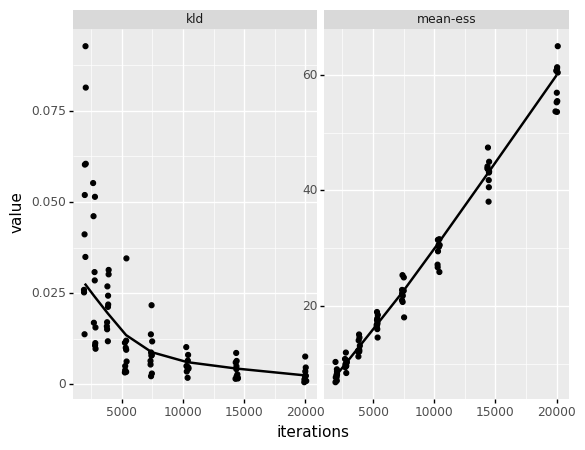

<ggplot: (8781110964336)>

In [3]:
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The ESS and KLD both trend in the correct directions.

Show example run results.

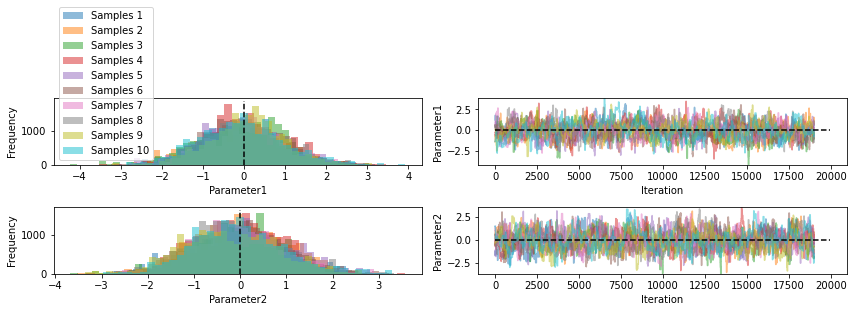

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  -0.06   0.98    -1.98   -0.72  -0.05  0.58   1.90     1.02    564.07  407.23
param 2  -0.05   1.00    -1.95   -0.75  -0.07  0.63   1.97     1.02    587.62  424.23


In [4]:
n_chains = 10
n_iterations = 20000
n_warmup = 1000
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.EmceeHammerMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The parameters are close to their true means. How do they compare to MCMC eCDFs compare with the theoretical? Look pretty good.

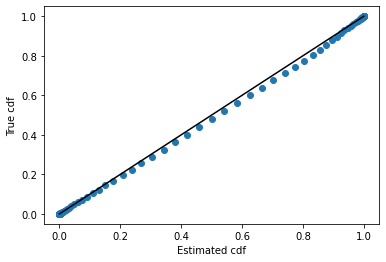

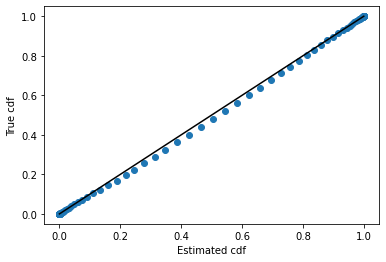

[None, None]

In [5]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

# Correlated Gaussian

In [6]:
test = run_replicates(np.geomspace(5000, 20000, 8), 10,
                      test_emcee_hammer_on_correlated_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/emcee_hammer_correlated_gaussian.csv")

/usr/local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


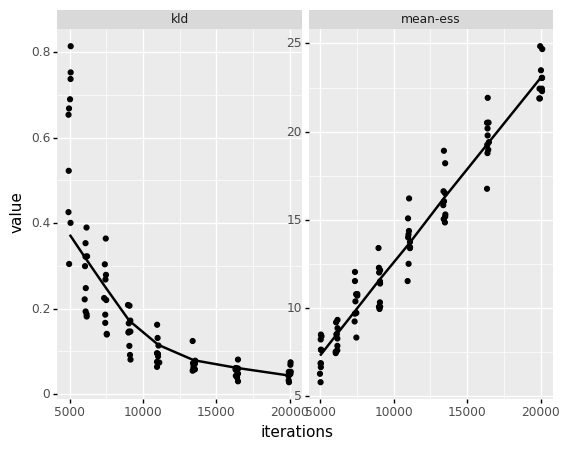

<ggplot: (8781115969768)>

In [7]:
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

Example run of results.

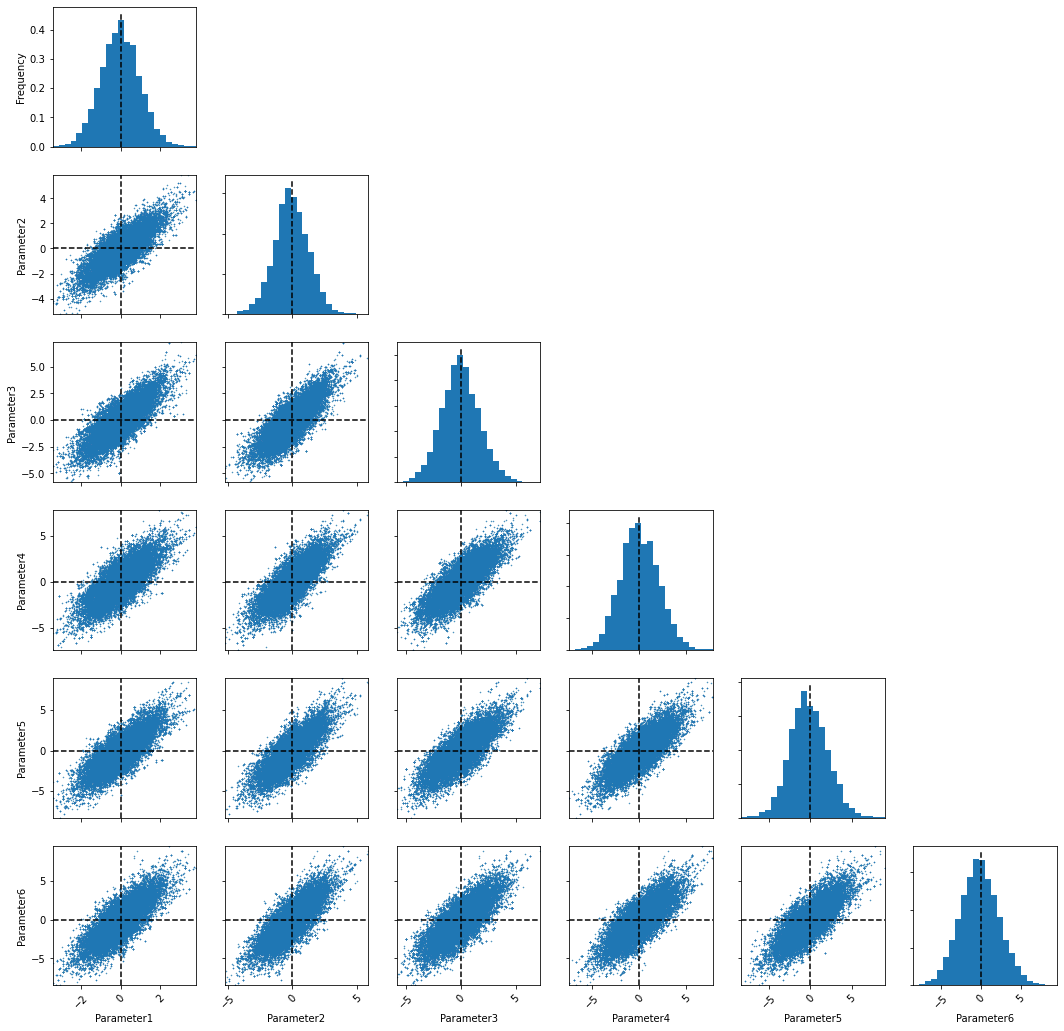

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  -0.00   0.98    -1.91   -0.65  -0.01  0.65   1.97     1.02    403.75  198.58
param 2  -0.08   1.36    -2.80   -0.94  -0.11  0.82   2.55     1.03    400.64  197.05
param 3  -0.06   1.72    -3.40   -1.21  -0.09  1.08   3.44     1.03    391.68  192.65
param 4  0.03    2.01    -3.77   -1.34  -0.04  1.39   4.00     1.04    411.68  202.48
param 5  -0.14   2.22    -4.35   -1.66  -0.25  1.34   4.36     1.04    403.59  198.50
param 6  -0.11   2.44    -4.83   -1.77  -0.16  1.48   4.76     1.02    412.13  202.70


In [8]:
n_chains = 10
n_iterations = 30000
n_warmup = 2000

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.EmceeHammerMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

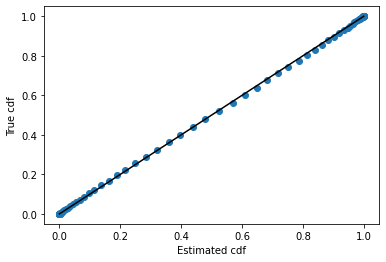

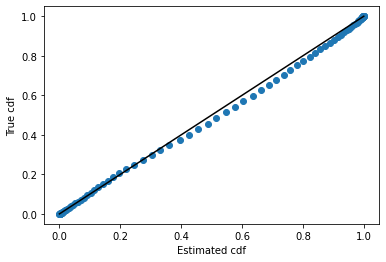

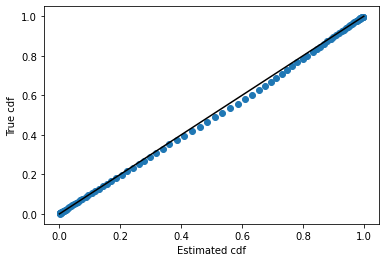

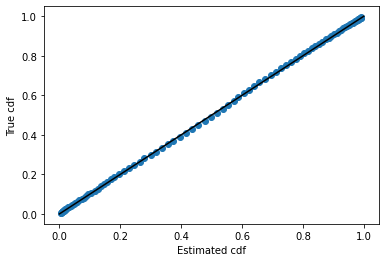

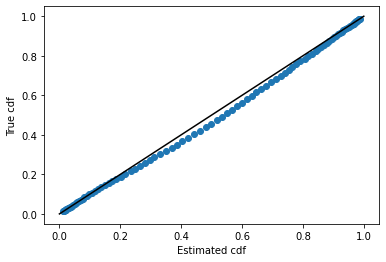

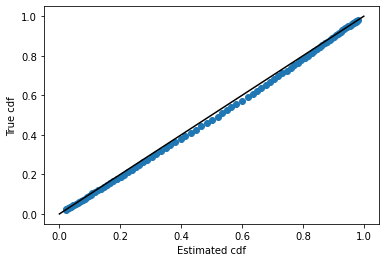

[None, None, None, None, None, None]

In [9]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Banana

In [10]:
test = run_replicates(np.geomspace(3000, 10000, 8), 10, test_emcee_hammer_on_banana)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/emcee_hammer_banana.csv")

/usr/local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


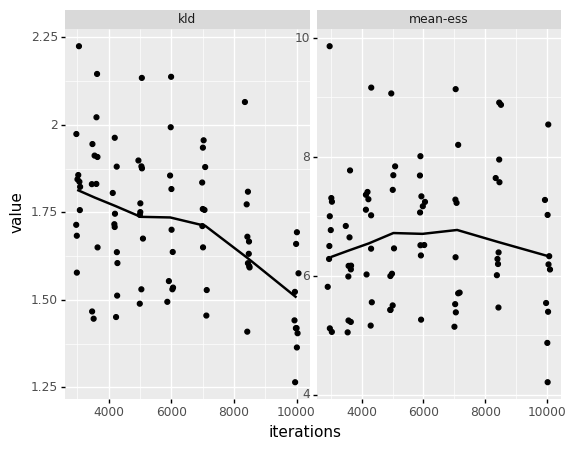

<ggplot: (8781118127312)>

In [11]:
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The banana is a hard problem. Because of this, both the ESS and KLD do not behave well. It's likely that this is due to the problem being too hard for this sampler, rather than there being an issue with the method itself.

Example run of results.

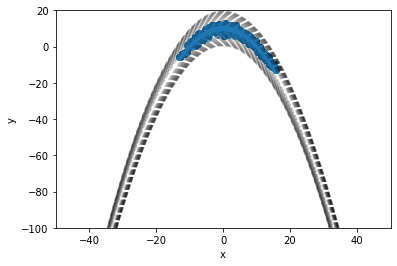

In [12]:
n_chains = 4
n_iterations = 4000
n_warmup = 1000

log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)
log_prior = pints.MultivariateGaussianLogPrior([0, 0],
                                               [[10, 0], [0, 10]])
x0 = log_prior.sample(n_chains)
sigma0 = np.diag(np.array([1, 3]))

levels = np.linspace(-50, -1, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.EmceeHammerMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlim(-50, 50)
plt.ylim(-100, 20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Annulus

In [13]:
test = run_replicates(np.geomspace(3000, 20000, 8), 10,
                      test_emcee_hammer_on_annulus)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/emcee_hammer_annulus.csv")

/usr/local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


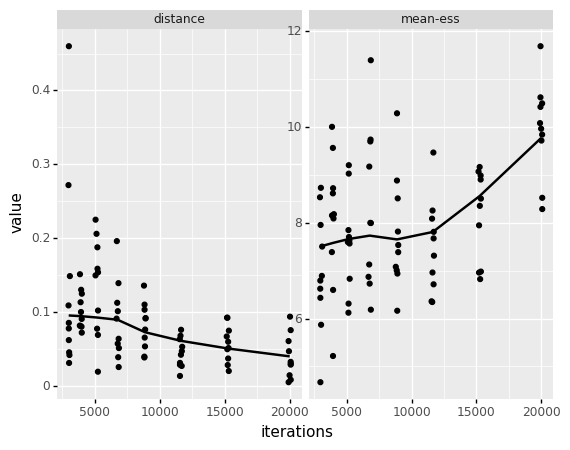

<ggplot: (8781128749349)>

In [14]:
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The draws trend closer to convergence as the number of iterations increases, although the effective sample size is low here.

Example run.

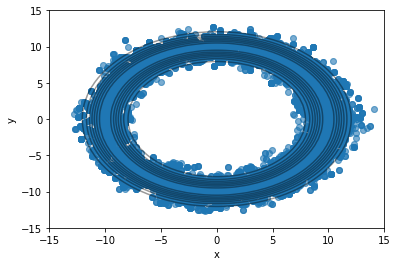

In [15]:
n_chains = 4
n_iterations = 20000
n_warmup = 2000

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.EmceeHammerMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Multimodal Gaussian

In [16]:
test = run_replicates(np.geomspace(3000, 10000, 8), 10,
                      test_emcee_hammer_on_multimodal_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/emcee_hammer_multimodal_gaussian.csv")

/usr/local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


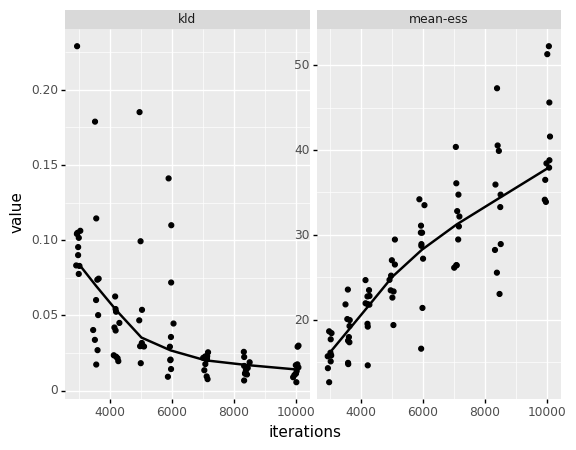

<ggplot: (8781117078450)>

In [17]:
# remove high values of kld to see general trend
test1 = test.query('kld < 1')
df1 = pd.melt(test1, id_vars=['iterations', 'replicate'])
(ggplot(df1,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

With the few outliers removed, the KLD appears to be moving in the correct direction as iterations increase.

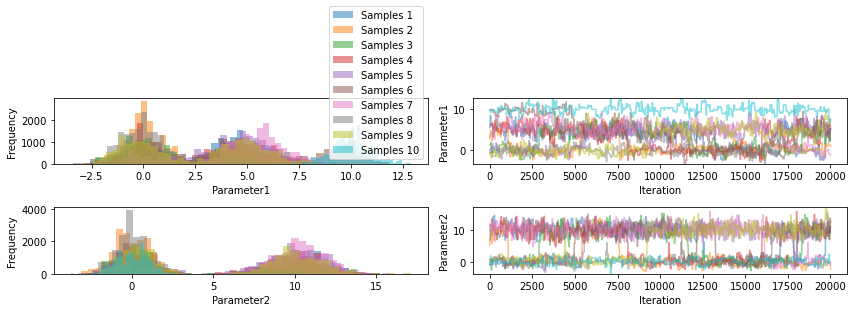

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  3.54    3.59    -1.59   0.18   3.75   5.85   10.72    1.74    197.79  83.23
param 2  4.77    5.17    -1.62   -0.02  1.75   9.93   12.74    1.39    153.24  64.48


In [18]:
n_chains = 10
n_iterations = 20000
n_warmup = 2000

covariances = [[[1, 0], [0, 1]],
               [[2, 0.8], [0.8, 3]],
               [[1, -0.5], [-0.5, 1]]]
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes=[[0, 0], [5, 10], [10, 0]],
                                             covariances=covariances)
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.EmceeHammerMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()

pints.plot.trace(chains)

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Clearly this multimodal distribution requires many draws to reach convergence.

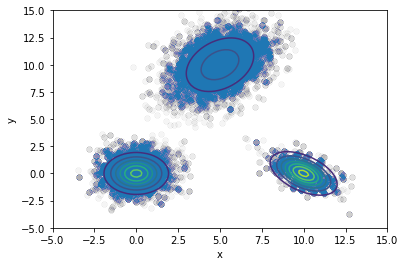

In [19]:
samples = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1], alpha=0.005)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Cone

In [20]:
test = run_replicates(np.geomspace(3000, 20000, 8), 10,
                      test_emcee_hammer_on_cone)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/emcee_hammer_cone.csv")

/usr/local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


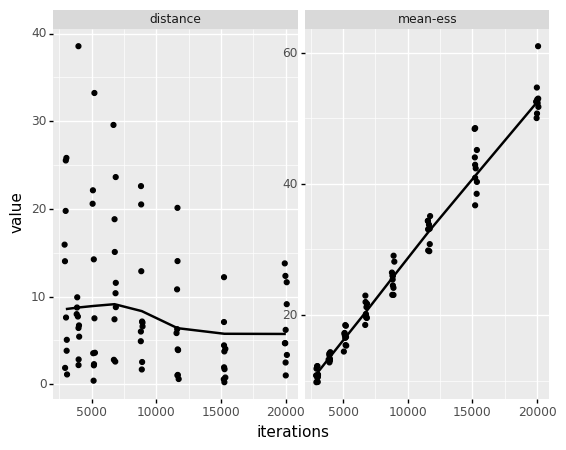

<ggplot: (8781116775530)>

In [21]:
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

Again, the cone problem, with its long tails, is really hard. But emcee hammer appears to be moving in the right direction as iterations increase.

Now showing an example run.

Running...
Done!
param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
mean dim 1  0.05    8.01    -16.38  -3.41  -0.09  3.41   17.46    1.02    465.23  447.85
mean dim 2  0.24    7.91    -15.52  -3.00  0.14   3.20   17.64    1.01    540.55  520.36


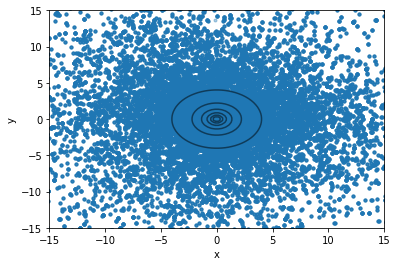

True normed mean = 8.638816024714002
Sample normed mean = 8.331864817790722
True normed var = 65.40423915068341
Sample normed var = 59.09974152265395


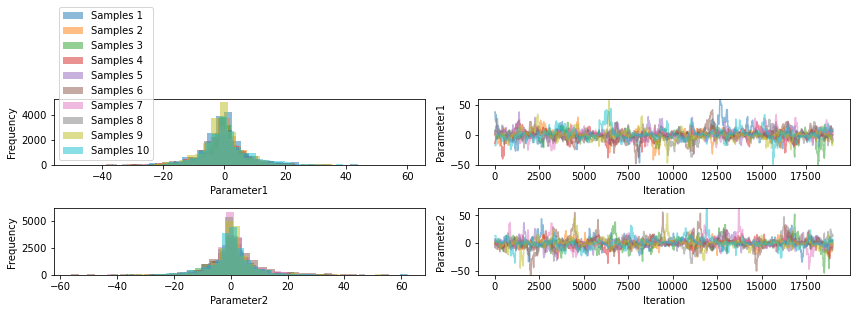

In [22]:
nchains = 10
log_pdf = pints.toy.ConeLogPDF(dimensions=2, beta=0.6)
x0 = log_pdf.sample(nchains)
mcmc = pints.MCMCController(log_pdf, nchains, x0, method=pints.EmceeHammerMCMC)

# Set maximum number of iterations
mcmc.set_max_iterations(20000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(),
                            parameter_names=['mean dim 1', 'mean dim 2'])
print(results)

# Discard warm-up
chains = [chain[1000:] for chain in chains]
stacked = np.vstack(chains)

# overlay draws on contours
num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

d = list(map(lambda x: np.linalg.norm(x), stacked))
a_mean = np.mean(d)
a_var = np.var(d)

print("True normed mean = " + str(log_pdf.mean_normed()))
print("Sample normed mean = " + str(a_mean))

print("True normed var = " + str(log_pdf.var_normed()))
print("Sample normed var = " + str(a_var))

# Show traces and histograms
pints.plot.trace(chains)
plt.show()